In [1]:
from google.colab import drive
drive.mount('/gdrive/', force_remount=True)

Mounted at /gdrive/


In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lygn8_s8
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lygn8_s8


In [3]:
!pip install opencv-python
!pip install -qqq wandb
!pip install -qqq pytorch-lightning

In [4]:
# Imports
from math import floor
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
from time import time
import os
from os import path

import torch
from torch import save, load
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import random_split, Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms, ops, utils
from torchvision.transforms import ToTensor, Resize

import pytorch_lightning as pl
import torchmetrics
import wandb
from pytorch_lightning.loggers import WandbLogger

In [5]:
# Define Hyperparameters
class Args(object):

  # for training
  batch_size = 2 # batchsize for training 
  learning_rate = 1e-4 # initial learning rate
  epochs = 50 # number of epochs for training
  momentum = 0.9 # momentum for SGD

args = Args()

In [6]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class OilSpillDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background

        # create a binarized mask
        mask = Image.open(mask_path)
        thresh = 10
        fn = lambda x : 255 if x > thresh else 0
        mask = mask.convert('L').point(fn, mode='1')
        mask = np.array(mask)
        
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        pos = np.where(masks[0,:,:])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [99]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)#,pretrained_backbone=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
#git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [100]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

In [101]:
root = '/gdrive/MyDrive/segmentation/training'
traindata = OilSpillDataset(root, get_transform(train=True))

root_val = '/gdrive/MyDrive/segmentation/validation'
valdata = OilSpillDataset(root_val, get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    traindata, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    valdata, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [111]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.6, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

In [112]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=3)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/7]  eta: 0:00:04  lr: 0.001675  loss: 3.2401 (3.2401)  loss_classifier: 0.8474 (0.8474)  loss_box_reg: 0.0660 (0.0660)  loss_mask: 2.2094 (2.2094)  loss_objectness: 0.0776 (0.0776)  loss_rpn_box_reg: 0.0397 (0.0397)  time: 0.7098  data: 0.0673  max mem: 5581
Epoch: [0]  [3/7]  eta: 0:00:02  lr: 0.006670  loss: 3.2401 (3.0034)  loss_classifier: 0.4015 (0.5462)  loss_box_reg: 0.0660 (0.0707)  loss_mask: 2.2094 (2.3117)  loss_objectness: 0.0302 (0.0400)  loss_rpn_box_reg: 0.0172 (0.0349)  time: 0.7324  data: 0.0724  max mem: 5581
Epoch: [0]  [6/7]  eta: 0:00:00  lr: 0.010000  loss: 1.2383 (2.1782)  loss_classifier: 0.1327 (0.3440)  loss_box_reg: 0.0660 (0.0628)  loss_mask: 0.9449 (1.6770)  loss_objectness: 0.0421 (0.0411)  loss_rpn_box_reg: 0.0397 (0.0532)  time: 0.7317  data: 0.0689  max mem: 5581
Epoch: [0] Total time: 0:00:05 (0.7321 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:00  model_time: 0.0577 (0.0577)  evaluator_time: 0.0009 (0.0009)  time: 0.

In [113]:
# pick one image from the test set
img, mask_data = valdata[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

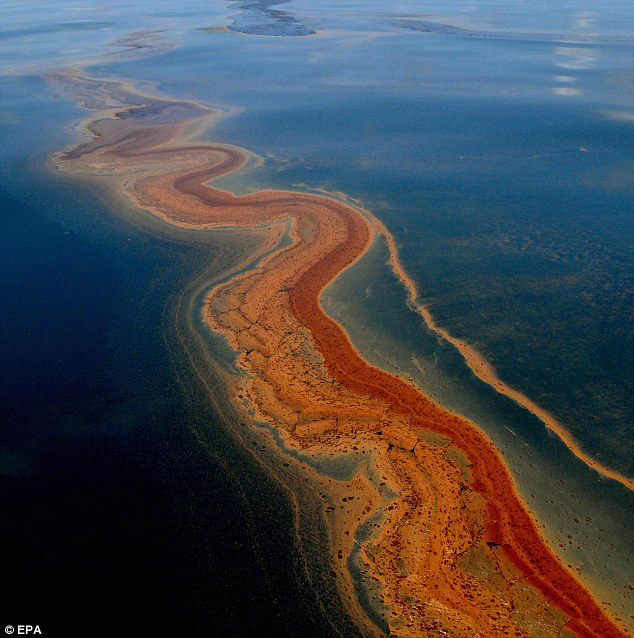

In [104]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

tensor([ 49.,  96., 632., 637.])


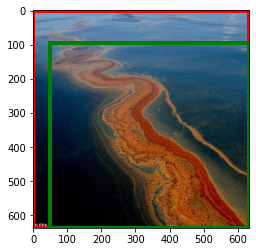

In [114]:
best_box = prediction[0]['boxes'][0]
gt_box = mask_data['boxes'][0]

fig, ax = plt.subplots()
ax.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
print(gt_box)
thickness = 4
pred_rect = patches.Rectangle((best_box[0], best_box[1]), best_box[2] - best_box[0], best_box[3] - best_box[1], linewidth=thickness, edgecolor='r', facecolor='none')
gt_rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1], linewidth=thickness, edgecolor='g', facecolor='none')
ax.add_patch(pred_rect)
ax.add_patch(gt_rect)

plt.show()

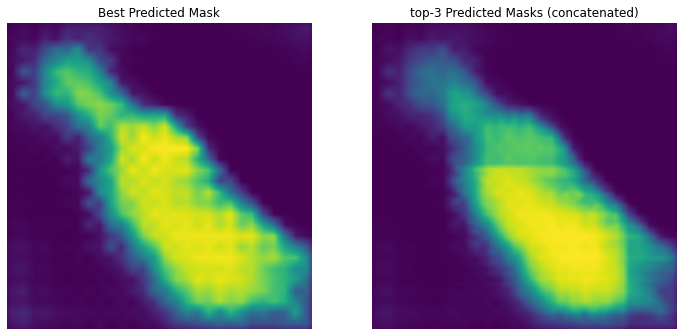

In [115]:
from copy import deepcopy
best_masks = prediction[0]['masks']
#print(best_masks)

# Create figure and axes
fig, ax = plt.subplots(1,2, figsize=(12, 6))

# # Create a Rectangle patch
concat_mask = deepcopy(best_masks[0])
for best_mask in best_masks[:3]:
  concat_mask += best_mask
ax[0].imshow(best_masks[0].permute(1, 2, 0).squeeze(-1).cpu().numpy())
ax[0].set_title('Best Predicted Mask')
ax[0].axis('off')
ax[1].imshow(concat_mask.permute(1, 2, 0).squeeze(-1).cpu().numpy())
ax[1].set_title('top-3 Predicted Masks (concatenated)')
ax[1].axis('off')

plt.show()

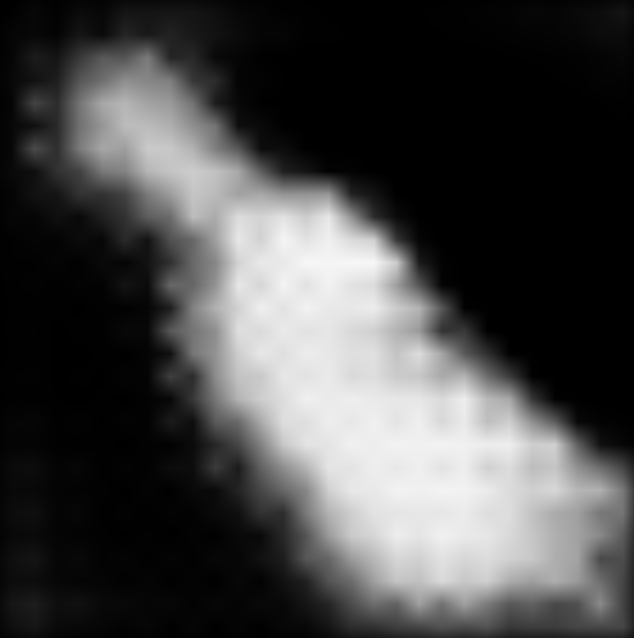

In [116]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

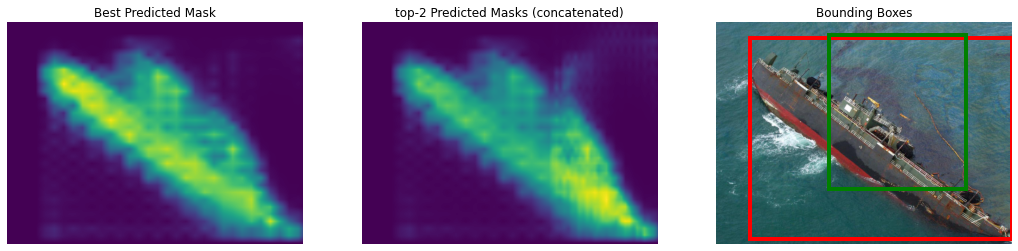

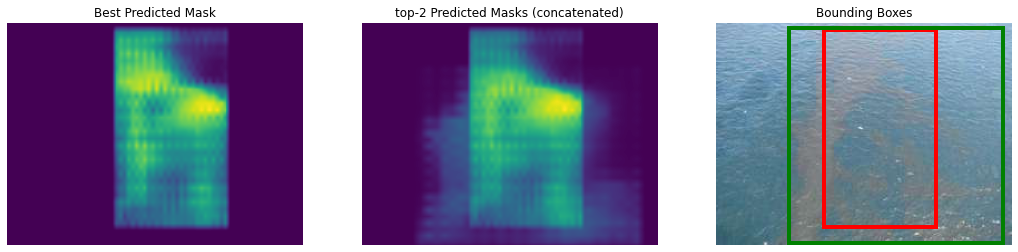

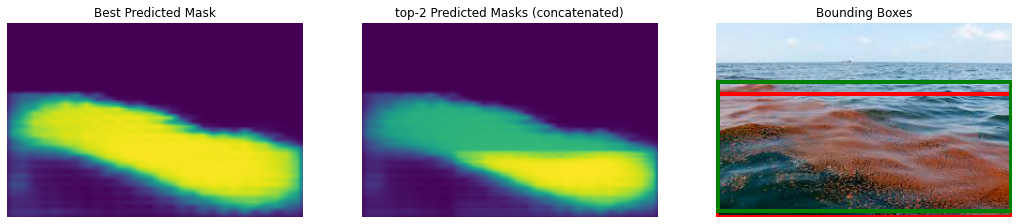

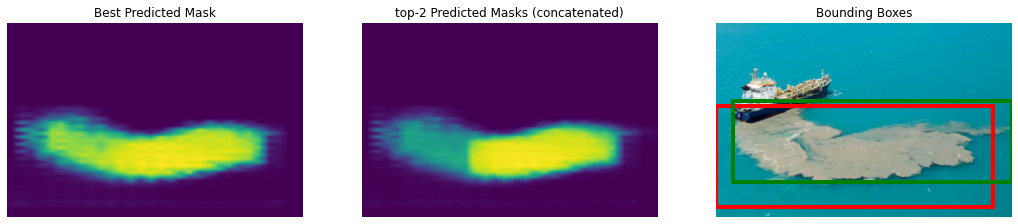

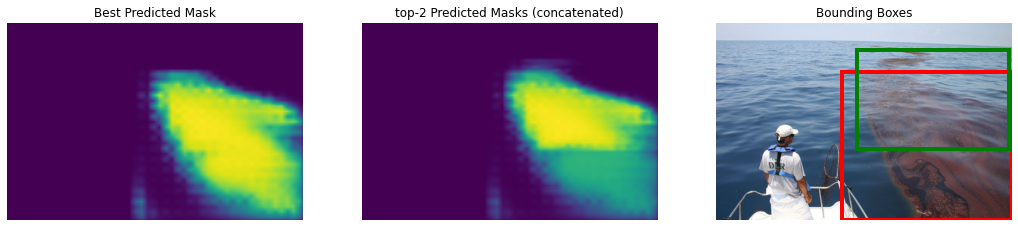

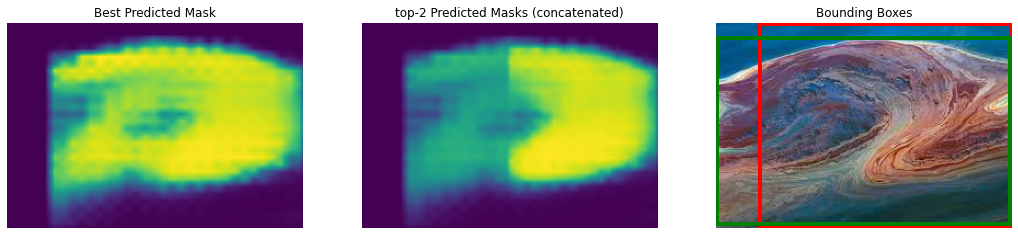

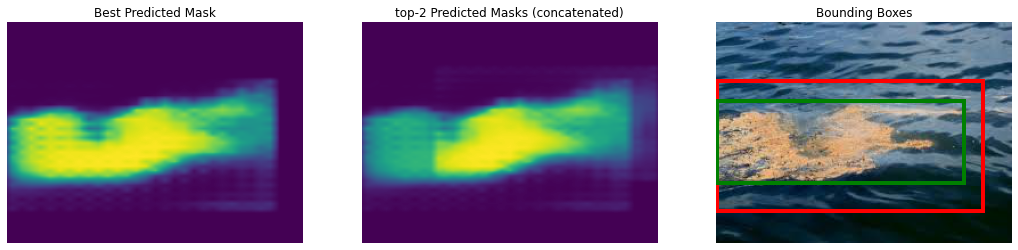

In [117]:
for i, v in enumerate(data_loader):
  img, mask_data = v
  img = img[0]
  if i >= 0:
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
        mask = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
        im.show()
        mask.show()

        best_masks = prediction[0]['masks']

        # Create figure and axes
        fig, ax = plt.subplots(1,3, figsize=(18, 6))

        # # Create a Rectangle patch
        concat_mask = deepcopy(best_masks[0])
        for best_mask in best_masks[:2]:
          concat_mask += best_mask
        ax[0].imshow(best_masks[0].permute(1, 2, 0).squeeze(-1).cpu().numpy())
        ax[0].set_title('Best Predicted Mask')
        ax[0].axis('off')
        ax[1].imshow(concat_mask.permute(1, 2, 0).squeeze(-1).cpu().numpy())
        ax[1].set_title('top-2 Predicted Masks (concatenated)')
        ax[1].axis('off')

        best_box = prediction[0]['boxes'][0]
        gt_box = mask_data[0]['boxes'][0]
        ax[2].imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
        thickness = 4
        pred_rect = patches.Rectangle((best_box[0], best_box[1]), best_box[2] - best_box[0], best_box[3] - best_box[1], linewidth=thickness, edgecolor='r', facecolor='none')
        gt_rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1], linewidth=thickness, edgecolor='g', facecolor='none')
        ax[2].add_patch(pred_rect)
        ax[2].add_patch(gt_rect)
        ax[2].set_title('Bounding Boxes')
        ax[2].axis('off')

        #plt.show()